# Deep Q-Network (DQN)

In [1]:
import gym.spaces
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from collections import deque, namedtuple

/Applications/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class ReplayMemory:
    
    def __init__(self, size):
        self.memory = deque(maxlen=size)
        self.experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])
    
    def add(self, state, action, reward, next_state, done):
        experience = self.experience(state, action, reward, next_state, done)
        self.memory.append(experience)
    
    def sample(self, batch_size):
        experiences = random.sample(self.memory, k=batch_size)
        states, actions, rewards, next_states, dones = zip(*experiences)
        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        return len(self.memory)

In [3]:
class DenseModel(tf.keras.Model):
    
    def __init__(self, state_size, action_size):
        super(DenseModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(64, input_shape=(None, state_size), activation='relu')
        self.dense2 = tf.keras.layers.Dense(64, activation='relu')
        self.dense3 = tf.keras.layers.Dense(action_size)
        
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.dense3(x)

In [4]:
MEMORY_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
LEARN_EVERY = 4        # how often to update the network
LEARN_FROM = BATCH_SIZE


class Agent:
    
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.time_step = 0
        
        self.states = tf.placeholder(tf.float32, shape=(None, state_size))
        self.actions = tf.placeholder(tf.int32, shape=(None))
        self.rewards = tf.placeholder(tf.float32, shape=(None))
        self.next_states = tf.placeholder(tf.float32, shape=(None, state_size))
        self.dones = tf.placeholder(tf.float32, shape=(None))
        
        # create graph
        self.local_q_model = DenseModel(state_size, action_size)
        self.target_q_model = DenseModel(state_size, action_size)
        
        max_next_action_values = tf.reduce_max(self.target_q_model(self.next_states), axis=1)
        target_action_values = self.rewards + GAMMA*max_next_action_values*(1. - self.dones)
        self.local_action_values = self.local_q_model(self.states)
        self.indices = tf.concat([tf.expand_dims(tf.range(tf.shape(self.actions)[0]), -1), tf.expand_dims(self.actions, -1)], 1)
        selected_local_action_values = tf.gather_nd(self.local_action_values, self.indices)
        self.loss = tf.losses.mean_squared_error(target_action_values, selected_local_action_values)
        self.optimize = tf.train.AdamOptimizer(LR).minimize(self.loss)
        
        # Inialize replay memory
        self.replay_memory = ReplayMemory(MEMORY_SIZE)
        
        # Initialize graph variables
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        self.soft_update(1.)
        self.target_q_model.trainable = False

    def act(self, state, eps=0.):
        if random.random() < eps:
            return random.choice(np.arange(self.action_size))
        else:
            values = {
                self.states: np.array([state])
            }
            local_action_values = self.sess.run([self.local_action_values], feed_dict=values)
            return np.argmax(local_action_values)
    
    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences
        values = {
            self.states: states,
            self.actions: actions,
            self.rewards: rewards,
            self.next_states: next_states,
            self.dones: dones
        }
        loss, _ = self.sess.run([self.loss, self.optimize], feed_dict=values)
        return loss

    def soft_update(self, tau):
        local_weights = np.array(self.local_q_model.get_weights())
        target_weights = np.array(self.target_q_model.get_weights())
        weights = list(tau*local_weights + (1. - tau)*target_weights)
        self.target_q_model.set_weights(weights)

    def step(self, state, action, reward, next_state, done):
        self.replay_memory.add(state, action, reward, next_state, done)
        self.time_step = self.time_step + 1
        if self.time_step >= LEARN_FROM and self.time_step % LEARN_EVERY == 0:
            experiences = self.replay_memory.sample(BATCH_SIZE)
            loss = self.learn(experiences)
            self.soft_update(1.)
            return loss
        else:
            return 0
                
    def save(self):
        self.local_q_model.save_weights('local_q_model_weights.h5')
        self.target_q_model.save_weights('target_q_model_weights.h5')
        
    def load(self):
        self.local_q_model.load_weights('local_q_model_weights.h5')
        self.target_q_model.load_weights('target_q_model_weights.h5')
        

In [5]:
def dqn(env, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.02, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    agent = Agent(env.observation_space.shape[0], env.action_space.n)
    
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    losses_window = deque(maxlen=100)
    actions_window = deque(maxlen=100)
    iteration = 0
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        episode_loss = 0
        actions = []
        for t in range(max_t):
            action = agent.act(state, eps)
            actions.append(action)
            next_state, reward, done, _ = env.step(action)
            loss = agent.step(state, action, reward, next_state, done)
            if reward == 200:
                print('reward 200')
            state = next_state
            score += reward
            episode_loss += loss
            iteration += 1
            if done:
                break
        scores_window.append(score)       # save most recent score
        losses_window.append(episode_loss)
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps)
        print('\rEpisode {}\tAverage Score: {:.2f}\tEpsilon {:.4f}\tIteration {}\tMemory {}\tActions {}'.format(i_episode, np.mean(scores_window), eps, iteration, len(agent.replay_memory), len(actions)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tEpsilon {:.4f}\tIteration {}\tMemory {}\tActions {}'.format(i_episode, np.mean(scores_window), eps, iteration, len(agent.replay_memory), len(actions)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            agent.save()
            break
    
    # plot the scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()
    
    return agent

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
State shape:  (4,)
Number of actions:  2
Episode 100	Average Score: 19.65	Epsilon 0.6058	Iteration 1965	Memory 1965	Actions 14
Episode 200	Average Score: 31.60	Epsilon 0.3670	Iteration 5125	Memory 5125	Actions 302
Episode 273	Average Score: 200.57	Epsilon 0.2545	Iteration 23690	Memory 23690	Actions 299
Environment solved in 173 episodes!	Average Score: 200.57


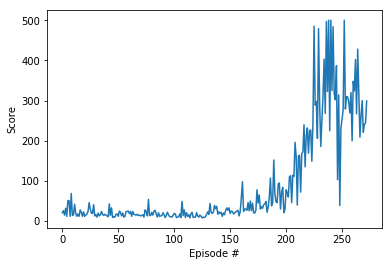

In [6]:
env = gym.make('CartPole-v1')
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)
agent = dqn(env)

State shape:  (8,)
Number of actions:  4


/Applications/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Episode 100	Average Score: -476.87	Epsilon 0.6058	Iteration 6828	Memory 6828	Actions 73
Episode 200	Average Score: -342.66	Epsilon 0.3670	Iteration 14067	Memory 14067	Actions 956
Episode 300	Average Score: -246.97	Epsilon 0.2223	Iteration 21125	Memory 21125	Actions 89
Episode 400	Average Score: -224.29	Epsilon 0.1347	Iteration 28154	Memory 28154	Actions 71
Episode 500	Average Score: -200.58	Epsilon 0.0816	Iteration 35240	Memory 35240	Actions 53
Episode 600	Average Score: -193.41	Epsilon 0.0494	Iteration 42249	Memory 42249	Actions 83
Episode 700	Average Score: -178.14	Epsilon 0.0299	Iteration 49185	Memory 49185	Actions 59
Episode 800	Average Score: -175.52	Epsilon 0.0200	Iteration 56247	Memory 56247	Actions 821
Episode 900	Average Score: -172.60	Epsilon 0.0200	Iteration 63336	Memory 63336	Actions 576
Episode 1000	Average Score: -178.65	Epsilon 0.0200	Iteration 70358	Memory 70358	Actions 57
Episode 1100	Average Score: -168.87	Epsilon 0.0200	Iteration 77453	Memory 77453	Actions 689
Episod

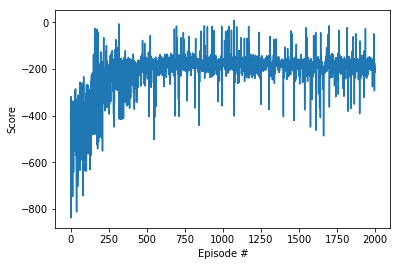

In [7]:
env = gym.make('LunarLander-v2')
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)
agent = dqn(env)

### 4. Watch a Smart Agent!

In [ ]:
for i in range(5):
    state = env.reset()
    done = False
    while not done:
        action = agent.act(state)
        env.render()
        state, reward, done, _ = env.step(action) 
env.close()